# Emerging topics final code - Full (new code cleaning)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import os

from gensim.models.coherencemodel import CoherenceModel

import statsmodels.api as sm

## Data ingestion

In [2]:
# full corpus
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")

In [3]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

In [5]:
'''
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['study'], \
                               id2word.token2id['project']])

    return id2word
'''

'\ndef createLDAvars(docs):\n\n    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus\n    \n    # Create Dictionary\n    id2word = gensim.corpora.Dictionary(docs)\n\n    #Filter words to only those found in at least a set number of documents (min_appearances)\n    id2word.filter_extremes(no_below=20, no_above=0.6)\n    \n    # filter out stop words - "use" already filtered out by previous line\n    id2word.filter_tokens(bad_ids=[id2word.token2id[\'research\'], id2word.token2id[\'study\'],                                id2word.token2id[\'project\']])\n\n    return id2word\n'

In [6]:
#id2word = createLDAvars(docs)

## Functions needed for all models

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [8]:
def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- 50 topics, random state = ?

In [9]:
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

In [10]:
# construct term document matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [11]:
# first time topic model run
#num_topics = 100

#nmf_model = NMF(n_components = num_topics, random_state = 1)
#doc_topic = nmf_model.fit_transform(tf_idf)
#topic_term = nmf_model.components_

In [12]:
#with open("/project/biocomplexity/sdad/projects_data/ncses/prd/nmf_full_100.pkl","wb") as f:
#    pickle.dump((doc_topic, topic_term), f)

In [13]:
# read in fit topic model
num_topics = 200

with open("/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/nmf_full_"+str(num_topics)+".pkl", "rb") as f:
    res = pickle.load(f)
    
doc_topic = res[0]
topic_term = res[1]

In [14]:
topics = list_topics(topic_term, tfidf_vectorizer, top_n = 10)

In [15]:
# calculate coherence
#cm = CoherenceModel(topics = topics,
#                    #corpus = corpus,
#                    dictionary = id2word,
#                    texts = docs, 
#                    coherence = 'c_v', 
#                    processes = 8)

## Emerging topics

In [16]:
# Extract Year from PROJECT_START_DATE

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [17]:
# add start year to doc topic matrix
topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]

In [18]:
st_yr = 2010
end_yr = 2018

#### compute count of projects with weight > 0 for each topic

In [19]:
topic_proj_count = topic_frame.copy()

In [20]:
# count number of docs with weight > 0
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [21]:
# count number of docs with weight > 0 BY YEAR
topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

In [22]:
# get docs between 2010 and 2019 (or st_yr and end_yr)

topic_counts_filt = topic_counts[topic_counts["START_YEAR"] >= st_yr] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] <= end_yr]

In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

In [24]:
len(n_by_topic)

200

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] >= st_yr] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] <= end_yr]

In [26]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [27]:
# filter topic_frame for years 2010 - 2019 (st_yr to end_yr)

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] >= st_yr] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] <= end_yr] 

In [28]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,...,Topic 175,Topic 176,Topic 177,Topic 178,Topic 179,Topic 180,Topic 181,Topic 182,Topic 183,Topic 184,Topic 185,Topic 186,Topic 187,Topic 188,Topic 189,Topic 190,Topic 191,Topic 192,Topic 193,Topic 194,Topic 195,Topic 196,Topic 197,Topic 198,Topic 199
40,2010,0.003928,0.000506,0.001235,0.000301,0.000816,0.000429,0.000551,0.000389,0.000031,0.000256,0.000218,0.001250,0.000283,0.001739,0.000014,0.001329,0.000178,0.000062,0.000006,0.000042,0.000092,0.000113,0.000193,0.000357,...,0.000213,0.000781,0.000190,0.000550,0.001289,0.000582,0.000421,0.000328,0.000522,0.000887,0.000738,0.000950,0.000359,0.000768,0.000310,0.000202,0.000341,0.000688,0.000608,0.001656,0.001088,0.000726,0.001114,0.000871,0.001010
41,2011,0.003961,0.000505,0.001275,0.000305,0.000855,0.000435,0.000556,0.000384,0.000031,0.000249,0.000229,0.001271,0.000275,0.001722,0.000014,0.001413,0.000176,0.000062,0.000006,0.000044,0.000096,0.000114,0.000181,0.000358,...,0.000227,0.000748,0.000209,0.000531,0.001357,0.000597,0.000446,0.000325,0.000542,0.000899,0.000714,0.001009,0.000382,0.000728,0.000324,0.000223,0.000370,0.000692,0.000651,0.001614,0.000898,0.000748,0.001078,0.000860,0.001011
42,2012,0.004141,0.000524,0.001307,0.000344,0.000884,0.000472,0.000560,0.000354,0.000035,0.000257,0.000253,0.001436,0.000265,0.001729,0.000014,0.001442,0.000178,0.000066,0.000006,0.000047,0.000091,0.000122,0.000216,0.000366,...,0.000244,0.000841,0.000209,0.000555,0.001464,0.000529,0.000451,0.000335,0.000588,0.000946,0.000615,0.001113,0.000401,0.000680,0.000325,0.000246,0.000445,0.000565,0.000643,0.001611,0.000822,0.000777,0.001083,0.000821,0.000968
43,2013,0.004210,0.000524,0.001286,0.000295,0.000858,0.000386,0.000568,0.000317,0.000032,0.000235,0.000228,0.001346,0.000319,0.001765,0.000013,0.001504,0.000176,0.000060,0.000006,0.000045,0.000103,0.000133,0.000190,0.000338,...,0.000262,0.001094,0.000220,0.000516,0.001315,0.000607,0.000401,0.000266,0.000544,0.000878,0.000777,0.000851,0.000361,0.000787,0.000320,0.000225,0.000421,0.000559,0.000648,0.001653,0.000900,0.000815,0.001235,0.000895,0.001092
44,2014,0.004165,0.000506,0.001327,0.000296,0.000894,0.000404,0.000566,0.000314,0.000031,0.000226,0.000246,0.001286,0.000287,0.001661,0.000013,0.001536,0.000179,0.000060,0.000006,0.000045,0.000105,0.000122,0.000184,0.000348,...,0.000256,0.000920,0.000206,0.000491,0.001329,0.000603,0.000435,0.000268,0.000560,0.000896,0.000763,0.000868,0.000358,0.000752,0.000305,0.000238,0.000421,0.000561,0.000610,0.001578,0.000910,0.000826,0.001273,0.000856,0.001032
45,2015,0.004272,0.000504,0.001300,0.000292,0.000850,0.000393,0.000584,0.000279,0.000033,0.000202,0.000240,0.001319,0.000310,0.001699,0.000012,0.001549,0.000176,0.000056,0.000006,0.000055,0.000116,0.000132,0.000182,0.000318,...,0.000250,0.001000,0.000232,0.000500,0.001313,0.000625,0.000410,0.000235,0.000542,0.000853,0.000853,0.000820,0.000292,0.000797,0.000383,0.000239,0.000401,0.000589,0.000635,0.001591,0.000918,0.000863,0.001303,0.000887,0.000934
46,2016,0.004240,0.000524,0.001307,0.000287,0.000805,0.000415,0.000571,0.000277,0.000035,0.000194,0.000272,0.001320,0.000326,0.001615,0.000011,0.001466,0.000169,0.000056,0.000006,0.000048,0.000114,0.000134,0.000186,0.000318,...,0.000269,0.000762,0.000185,0.000498,0.001329,0.000632,0.000432,0.000250,0.000549,0.000875,0.000791,0.000836,0.000278,0.000785,0.000357,0.000242,0.000391,0.000626,0.000665,0.001612,0.000920,0.000867,0.001344,0.000847,0.000956
47,2017,0.004296,0.000538,0.001402,0.000304,0.000822,0.000441,0.000588,0.000286,0.000038,0.000199,0.000293,0.001309,0.000323,0.001590,0.000011,0.001438,0.000168,0.000058,0.000007,0.000048,0.000115,0.000136,0.000174,0.000330,...,0.000270,0.000454,0.000208,0.000492,0.001380,0.000632,0.000481,0.000258,0.000552,0.000895,0.000728,0.000898,0.000297,0.000752,0.0

In [29]:
# fit OLS and get slope, SE, p-value
topic_slopes = []
topic_slopes_se = []
topic_slopes_pval = []

lm_x = topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1)
lm_x = sm.add_constant(lm_x)

for i in range(1,num_topics+1):

    linear_fit = sm.OLS(topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1),lm_x).fit()
    
    topic_slopes.append(linear_fit.params[1])
    topic_slopes_se.append(linear_fit.bse[1])
    topic_slopes_pval.append(linear_fit.pvalues[1])

In [30]:
topic_ols_res = pd.DataFrame(
    {"Slope": topic_slopes, 
     "SE": topic_slopes_se,
     "p-value": topic_slopes_pval
     #"n": n_by_topic
    })

In [31]:
topic_ols_res = topic_ols_res.reset_index(drop = True)

In [32]:
reg_topics = pd.DataFrame()
reg_topics["Topic Words"] = str_topics(topic_term, tfidf_vectorizer, top_n = 5)

In [33]:
regression_res = pd.concat([reg_topics, topic_ols_res], axis = 1)

In [34]:
regression_res = regression_res.sort_values('Topic Words')

In [35]:
topic_label_num = range(1, num_topics + 1)
topic_label = ["Z" + str(x) for x in topic_label_num]
regression_res["Topic Label"] = topic_label

In [36]:
regression_res

,Topic Words,Slope,SE,p-value,Topic Label
56,"activity, physical, outreach, increase, coordi...",1.734108e-06,9.257857e-07,0.103204,Z1
43,"ad, alzheimer, tau, dementia, pathology",2.830405e-06,4.799211e-07,0.000601,Z2
28,"administrative, scientific, coordinate, commun...",4.420212e-06,1.078101e-06,0.004573,Z3
171,"adolescent, youth, family, substance, parent",-5.666846e-06,2.189543e-06,0.036042,Z4
153,"adult, older, age, young, life",3.195800e-06,1.664787e-06,0.096380,Z5
...,...,...,...,...,...
72,"water, quality, irrigation, watershed, groundw...",-3.011552e-07,1.255951e-06,0.817369,Z196
85,"weight, loss, body, gain, diet",-9.262799e-07,2.311433e-07,0.005141,Z197
93,"woman, ovarian, man, female, reproductive",-2.240222e-06,6.919903e-07,0.014305,Z198
110,"workshop, researcher, participant, internation...",3.198094e-06,7.585993e-07,0.003957,Z199


In [37]:
#regression_res.to_csv("full_50_topics_2018_df.csv", index=False)

## Create plot - top 10 hot and cold topics

In [38]:
top_slopes = regression_res.nlargest(10, 'Slope')

In [39]:
top_slopes

,Topic Words,Slope,SE,p-value,Topic Label
0,"new, development, develop, discovery, approach",0.000045,8.073701e-06,8.016449e-04,Z122
197,"theory, mathematics, mathematical, space, geom...",0.000031,7.960164e-06,5.539328e-03,Z181
167,"device, sensor, power, design, wireless",0.000027,3.986697e-06,2.662553e-04,Z46
189,"tbi, traumatic, injury, outcome, blast",0.000022,6.346249e-06,9.495960e-03,Z178
53,"stem, hsc, hematopoietic, progenitor, college",0.000020,1.049951e-06,2.823166e-07,Z169
157,"technology, platform, develop, enable, industry",0.000017,2.260654e-06,1.371809e-04,Z180
196,"decision, process, choice, decision_making, task",0.000017,3.176470e-06,1.206966e-03,Z45
165,"software, tool, user, computing, computer",0.000016,2.734906e-06,5.363461e-04,Z164
169,"biomarker, detection, early, marker, assay",0.000016,2.442898e-06,3.757901e-04,Z19
125,"support, provide, infrastructure, continue, re...",0.000012,9.577569e-07,3.768985e-06,Z174


In [40]:
top_slopes.index

Int64Index([0, 197, 167, 189, 53, 157, 196, 165, 169, 125], dtype='int64')

In [41]:
start_wts = topic_wts_2010_2019[topic_wts_2010_2019['START_YEAR'] == st_yr]
start_wts = start_wts.iloc[:,top_slopes.index + 1]
start_wts


,Topic 0,Topic 197,Topic 167,Topic 189,Topic 53,Topic 157,Topic 196,Topic 165,Topic 169,Topic 125
40,0.003928,0.001114,0.000605,0.00031,0.000303,0.000426,0.000726,0.000418,0.000576,0.000523


In [42]:
start_wts.sort_values(by=40, axis=1, ascending = False)

,Topic 0,Topic 197,Topic 196,Topic 167,Topic 169,Topic 125,Topic 157,Topic 165,Topic 189,Topic 53
40,0.003928,0.001114,0.000726,0.000605,0.000576,0.000523,0.000426,0.000418,0.00031,0.000303


In [43]:
leg_order_idx = np.argsort(start_wts.iloc[0,:].tolist())[::-1]
leg_order_idx

array([0, 1, 6, 2, 8, 9, 5, 7, 3, 4])

In [44]:
leg_order = top_slopes.index[leg_order_idx]
leg_order

Int64Index([0, 197, 196, 167, 169, 125, 157, 165, 189, 53], dtype='int64')

In [45]:
top_slopes = top_slopes.loc[leg_order]

In [46]:
top_slopes

,Topic Words,Slope,SE,p-value,Topic Label
0,"new, development, develop, discovery, approach",0.000045,8.073701e-06,8.016449e-04,Z122
197,"theory, mathematics, mathematical, space, geom...",0.000031,7.960164e-06,5.539328e-03,Z181
196,"decision, process, choice, decision_making, task",0.000017,3.176470e-06,1.206966e-03,Z45
167,"device, sensor, power, design, wireless",0.000027,3.986697e-06,2.662553e-04,Z46
169,"biomarker, detection, early, marker, assay",0.000016,2.442898e-06,3.757901e-04,Z19
125,"support, provide, infrastructure, continue, re...",0.000012,9.577569e-07,3.768985e-06,Z174
157,"technology, platform, develop, enable, industry",0.000017,2.260654e-06,1.371809e-04,Z180
165,"software, tool, user, computing, computer",0.000016,2.734906e-06,5.363461e-04,Z164
189,"tbi, traumatic, injury, outcome, blast",0.000022,6.346249e-06,9.495960e-03,Z178
53,"stem, hsc, hematopoietic, progenitor, college",0.000020,1.049951e-06,2.823166e-07,Z169


In [47]:
top_leg_topic_label = top_slopes['Topic Label'].tolist()
top_leg = top_slopes['Topic Words'].tolist()
top_leg_label = [i + ": " + j for i, j in zip(top_leg_topic_label, top_leg)]

In [48]:
bottom_slopes = regression_res.nsmallest(10, 'Slope')

In [49]:
bottom_slopes

,Topic Words,Slope,SE,p-value,Topic Label
176,"crop, pest, agricultural, farmer, grower",-0.000048,0.000028,0.130490,Z43
13,"information, provide, database, communication,...",-0.000026,0.000005,0.001753,Z88
199,"pi, co, work, propose, undergraduate",-0.000020,0.000007,0.026378,Z134
186,"disorder, depression, anxiety, schizophrenia, ...",-0.000018,0.000011,0.140350,Z50
174,"forest, ecosystem, tree, land, fire",-0.000018,0.000010,0.128563,Z67
7,"protein, folding, proteomic, complex, interaction",-0.000015,0.000002,0.000330,Z145
163,"insulin, glucose, metabolic, secretion, beta",-0.000015,0.000002,0.000030,Z92
187,"p_53, apoptosis, induce, damage, mdm2",-0.000014,0.000003,0.005237,Z127
182,"ethanol, withdrawal, induce, chronic, consumption",-0.000013,0.000003,0.002203,Z60
198,"surface, biofilm, adhesion, coating, formation",-0.000012,0.000005,0.064303,Z175


In [50]:
bottom_slopes.index

Int64Index([176, 13, 199, 186, 174, 7, 163, 187, 182, 198], dtype='int64')

In [51]:
start_wts = topic_wts_2010_2019[topic_wts_2010_2019['START_YEAR'] == st_yr]
start_wts = start_wts.iloc[:,bottom_slopes.index + 1]
start_wts


,Topic 176,Topic 13,Topic 199,Topic 186,Topic 174,Topic 7,Topic 163,Topic 187,Topic 182,Topic 198
40,0.000781,0.001739,0.00101,0.00095,0.000383,0.000389,0.000393,0.000359,0.000328,0.000871


In [52]:
start_wts.sort_values(by=40, axis=1, ascending = False)

,Topic 13,Topic 199,Topic 186,Topic 198,Topic 176,Topic 163,Topic 7,Topic 174,Topic 187,Topic 182
40,0.001739,0.00101,0.00095,0.000871,0.000781,0.000393,0.000389,0.000383,0.000359,0.000328


In [53]:
leg_order_idx = np.argsort(start_wts.iloc[0,:].tolist())[::-1]
leg_order_idx

array([1, 2, 3, 9, 0, 6, 5, 4, 7, 8])

In [54]:
leg_order = bottom_slopes.index[leg_order_idx]
leg_order

Int64Index([13, 199, 186, 198, 176, 163, 7, 174, 187, 182], dtype='int64')

In [55]:
bottom_slopes = bottom_slopes.loc[leg_order]

In [56]:
bottom_slopes

,Topic Words,Slope,SE,p-value,Topic Label
13,"information, provide, database, communication,...",-0.000026,0.000005,0.001753,Z88
199,"pi, co, work, propose, undergraduate",-0.000020,0.000007,0.026378,Z134
186,"disorder, depression, anxiety, schizophrenia, ...",-0.000018,0.000011,0.140350,Z50
198,"surface, biofilm, adhesion, coating, formation",-0.000012,0.000005,0.064303,Z175
176,"crop, pest, agricultural, farmer, grower",-0.000048,0.000028,0.130490,Z43
163,"insulin, glucose, metabolic, secretion, beta",-0.000015,0.000002,0.000030,Z92
7,"protein, folding, proteomic, complex, interaction",-0.000015,0.000002,0.000330,Z145
174,"forest, ecosystem, tree, land, fire",-0.000018,0.000010,0.128563,Z67
187,"p_53, apoptosis, induce, damage, mdm2",-0.000014,0.000003,0.005237,Z127
182,"ethanol, withdrawal, induce, chronic, consumption",-0.000013,0.000003,0.002203,Z60


In [57]:
bottom_leg_topic_label = bottom_slopes['Topic Label'].tolist()
bottom_leg = bottom_slopes['Topic Words'].tolist()
bottom_leg_label = [i + ": " + j for i, j in zip(bottom_leg_topic_label, bottom_leg)]

### Plot hottest and coldest topics on separate plots

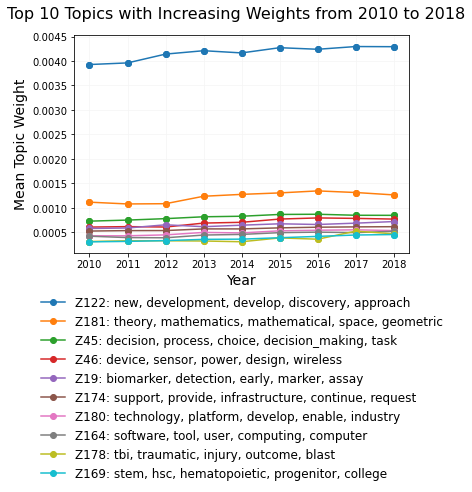

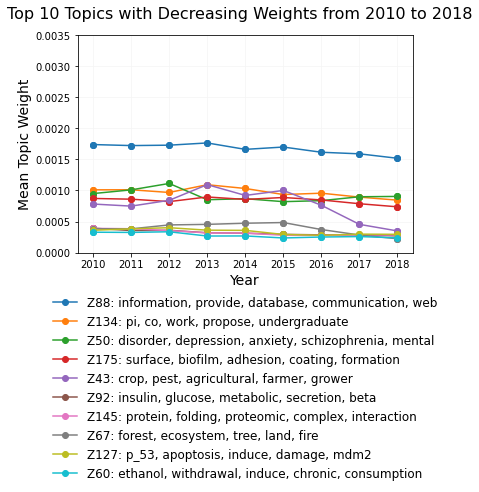

In [58]:
# Make Graphs

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

linestyle_tuple = [
     (0, (1, 10)),
     (0, (1, 1)),

     (0, (5, 10)),
     (0, (5, 5)),
     (0, (5, 1)),

     (0, (3, 10, 1, 10)),
     (0, (3, 5, 1, 5)),
     (0, (3, 1, 1, 1)),

     (0, (3, 5, 1, 5, 1, 5)),
     (0, (3, 10, 1, 10, 1, 10)),
     (0, (3, 1, 1, 1, 1, 1))]

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Increasing Weights from '+str(st_yr)+' to '+str(end_yr), fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes.index:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color = color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([top_leg_label[x] for x in range(0,len(top_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
plt.savefig("et_paper/full_increasing_"+str(num_topics)+"_topics_"+str(end_yr)+".pdf", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top 10 Topics with Decreasing Weights from '+str(st_yr)+' to '+str(end_yr), fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes.index:
    zorder = 10
    color = color_list[i]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i]
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder)
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], '-o', color=color, zorder = zorder, linestyle=linestyle_tuple[i])
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n+1], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n+1]), fmt = 'o', color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    #line_return.append(mcol.LineCollection(line, linestyles=linestyle_tuple, colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = 0, top = 0.0035)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([bottom_leg_label[x] for x in range(0,len(bottom_leg_label))], bbox_to_anchor=(0.35, -0.35, 0.3, 0.2), 
           loc='upper center', fontsize = 'large', frameon = False)
plt.savefig("et_paper/full_decreasing_"+str(num_topics)+"_topics_"+str(end_yr)+".pdf", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [ ]:
sorted_slopes = regression_res.sort_values('Slope', ascending = False)

In [ ]:
leg_topic_label = sorted_slopes['Topic Label'].tolist()
leg = sorted_slopes['Topic Words'].tolist()
topic_n = sorted_slopes['n'].tolist()
leg_label = [i + ": " + j for i, j in zip(leg_topic_label, leg)]

In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[0:25].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 1)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part1.png", dpi = 800, bbox_inches = "tight")
plt.show()



In [ ]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = 0, top = 0.004)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes.iloc[25:50].index):
    
    #col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,(col_idx+1)].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,(col_idx+1)], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,(col_idx+1)]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    #if count == 0:
    #    ax[i,j].set_title('administrative, scientific, meeting, \n coordinate, management', \
    #                      fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    ax[i,j].set_title(leg[count+25], fontsize = 8)
    
    # add topic number to each plot
    #ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[i,j].transAxes, fontsize = 14)
    #ax[i,j].text(0.08, 0.90, str(col_idx), horizontalalignment='center', verticalalignment='center', \
    #         transform=ax[i,j].transAxes, fontsize = 14)
    ax[i,j].text(0.1, 0.90, leg_topic_label[count+25], horizontalalignment='center', verticalalignment='center', \
         transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.65, 0.90, "n = " + str(topic_n[count+25]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
fig.suptitle('Full Corpus Topic Trends from 2010 to 2019 (Part 2)', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("full_50_topic_trends_2018_part2.png", dpi = 800, bbox_inches = "tight")
plt.show()